In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf

from src.utils import get_root_path, get_imgs_paths
from src.models.image_generator import get_image_generator

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from PIL import Image


from tensorflow.keras import layers, losses
import src.my_dataset as ds

In [7]:
all_images = []
paths = get_imgs_paths()[:1000]

for i in tqdm(paths):
    img = tf.keras.preprocessing.image.load_img(i, target_size=(384, 384, 3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.
    all_images.append(img)

all_images = np.array(all_images)
# all_images.shape


  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
from sklearn.model_selection import train_test_split


rankings = pd.read_csv(get_root_path() / 'data/interim/attributes.csv',
                       index_col=0).set_index('fileName').sort_index().filter(regex='_no', axis=1)

targets = rankings.loc[[str(i) for i in paths], 'charming_no']


X_train, X_test = train_test_split(all_images[(targets == 5).values], test_size=0.25)


Epoch 1/10
6/6 [==============================] - 16s 2s/step - loss: 0.1088 - val_loss: 0.1010
Epoch 2/10
6/6 [==============================] - 14s 2s/step - loss: 0.1045 - val_loss: 0.0953
Epoch 3/10
6/6 [==============================] - 14s 2s/step - loss: 0.0966 - val_loss: 0.0877
Epoch 4/10
6/6 [==============================] - 14s 2s/step - loss: 0.0878 - val_loss: 0.0842
Epoch 5/10
6/6 [==============================] - 23s 4s/step - loss: 0.0828 - val_loss: 0.0781
Epoch 6/10
6/6 [==============================] - 21s 3s/step - loss: 0.0766 - val_loss: 0.0727
Epoch 7/10
6/6 [==============================] - 16s 3s/step - loss: 0.0707 - val_loss: 0.0673
Epoch 8/10
6/6 [==============================] - 18s 3s/step - loss: 0.0650 - val_loss: 0.0622
Epoch 9/10
6/6 [==============================] - 18s 3s/step - loss: 0.0600 - val_loss: 0.0581
Epoch 10/10
6/6 [==============================] - 15s 3s/step - loss: 0.0560 - val_loss: 0.0547


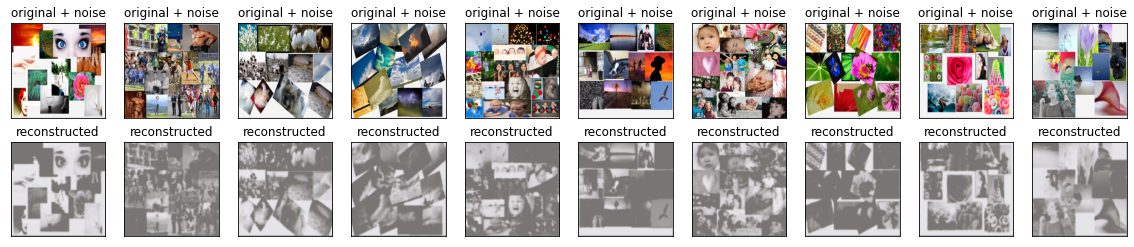

In [39]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(384, 384, 3)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(X_train, X_train,
                epochs=10,
                validation_data=(X_test, X_test),
                shuffle=True)


encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()



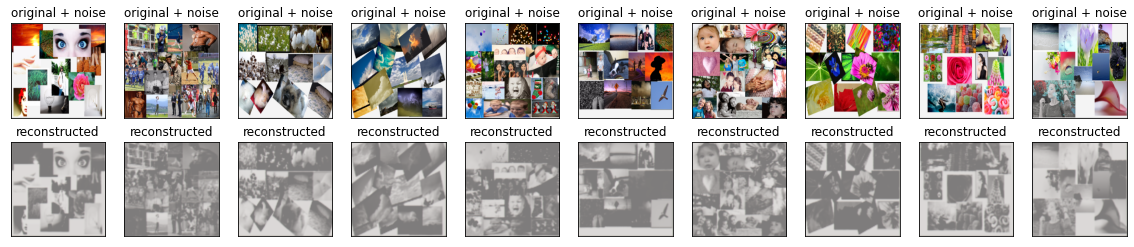

In [60]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Define the model
model = Sequential()

#1st convolution layer
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(384,384,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#-------------------------
#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#-------------------------

model.add(Conv2D(3,(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer='adam', loss=losses.MeanAbsoluteError())

# Generate data from the images in a folder
batch_size = 8
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    get_root_path()/'data/raw/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='input'
    )
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = test_datagen.flow_from_directory(
    get_root_path()/'data/raw/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='input'
    )
    
# Train the model
model.fit(
        X_train, X_train,
        # steps_per_epoch=1000 // batch_size,
        epochs=20,
        validation_data=(X_test, X_test),
        # validation_steps=1000 // batch_size
        )
        

# # Test the model
# data_list = []
# batch_index = 0
# while batch_index <= train_generator.batch_index:
#     data = train_generator.next()
#     data_list.append(data[0])
#     batch_index = batch_index + 1
# data_list[0].shape

# predicted = model.predict(data_list[0])
# plt.imshow(data_list[0][0])
# plt.imshow(predicted[0])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 384, 384, 16)      448       
                                                                 
 activation_45 (Activation)  (None, 384, 384, 16)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 192, 192, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 192, 192, 2)       290       
                                                                 
 activation_46 (Activation)  (None, 192, 192, 2)       0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 96, 96, 2)        0         
 g2D)                                                

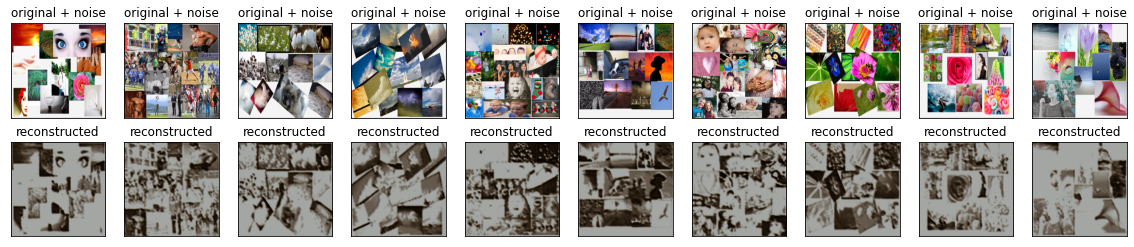

In [62]:
decoded_imgs = model(X_test).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()


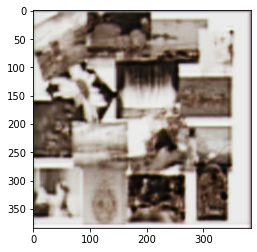

In [59]:
plt.imshow((tf.squeeze(decoded_imgs[0]) * 255).numpy().astype(int))

In [ ]:

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()
